In [10]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_iris
iris = load_iris()

In [ ]:
iris.data

In [ ]:
iris.target

In [11]:
from sklearn.model_selection import train_test_split
X, y = iris.data, iris.target

# Split data: 70% train, 30% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)


| Model               | Hyperparameter                        | Typical Range           |
| :------------------ | :------------------------------------ | :---------------------- |
| KNN                 | `n_neighbors`                         | 1–25                    |
| Logistic Regression | `C` (inverse regularization strength) | [0.01, 0.1, 1, 10, 100] |
| SVM                 | `C`                                   | [0.01, 0.1, 1, 10, 100] |
| Decision Tree       | `max_depth`                           | 1–10                    |


In [ ]:
from sklearn.neighbors import KNeighborsClassifier


We’re starting with KNN, a simple distance-based classifier.

The key hyperparameter is n_neighbors: how many neighbors to consider when classifying a new sample.

In [17]:
model = KNeighborsClassifier()
param_grid = {"n_neighbors": range(1, 26)}

Grid search is a hyperparameter tuning method for machine learning. We search for best possible combinations of hyperparameters (model parameters, not input data) for the given model.

Scikit learn has a function that can help us using cross-validation. Here is an example of how a 5-fold cross-validation may look like:
| Round | Train on                      | Validate on |
| :---- | :---------------------------- | :---------- |
| 1     | Fold₂ + Fold₃ + Fold₄ + Fold₅ | Fold₁       |
| 2     | Fold₁ + Fold₃ + Fold₄ + Fold₅ | Fold₂       |
| 3     | Fold₁ + Fold₂ + Fold₄ + Fold₅ | Fold₃       |
| 4     | Fold₁ + Fold₂ + Fold₃ + Fold₅ | Fold₄       |
| 5     | Fold₁ + Fold₂ + Fold₃ + Fold₄ | Fold₅       |

Scikit learn can do the cross-validation for us, and will report the parameters that gives us the best cross-validation accuracy, e.g. the average acurracy over the 5 train-validate-cases above. 

In [18]:
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(model, param_grid, cv=5)  # cv=5 means 5-fold cross-validation.
grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)
print("Best cross-validation accuracy:", grid.best_score_)


Best parameters: {'n_neighbors': 9}
Best cross-validation accuracy: 0.980952380952381


grid.best_estimator_ will give us the KNNModel with the best hyperparameters for the problem. We can then do predictions directly, as the model has already been trained in the previous step. 

In [19]:
best_knn = grid.best_estimator_

y_pred_train = best_knn.predict(X_train)
y_pred_test = best_knn.predict(X_test)

from sklearn.metrics import accuracy_score

print("Train accuracy:", accuracy_score(y_train, y_pred_train))
print("Test accuracy:", accuracy_score(y_test, y_pred_test))


Train accuracy: 0.9714285714285714
Test accuracy: 0.9555555555555556


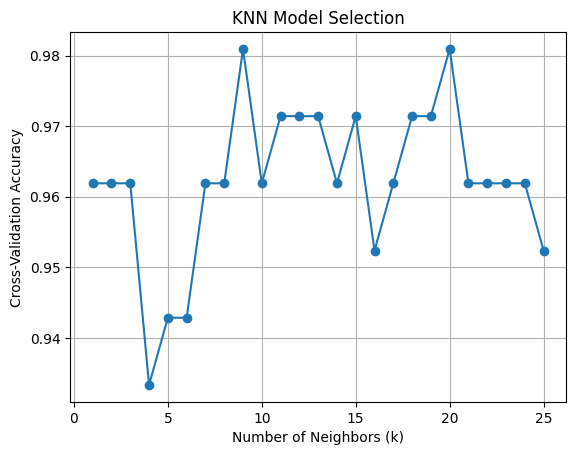

In [20]:
import matplotlib.pyplot as plt

cv_results = grid.cv_results_
plt.plot(param_grid["n_neighbors"], cv_results["mean_test_score"], marker="o")
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Cross-Validation Accuracy")
plt.title("KNN Model Selection")
plt.grid(True)
plt.show()


Now we have found the "best" KNN-model we can repeat the process for a few other common ML-models: 

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [40]:
models = {
    "KNN": (KNeighborsClassifier(), {"n_neighbors": range(1, 25)}),
    "LogReg": (LogisticRegression(max_iter=200), {"C": [0.01, 0.1, 1, 10, 100,100]}),
    "SVM": (SVC(), {"C": [0.01, 0.1, 1, 10, 100]}),
    "DecisionTree": (DecisionTreeClassifier(random_state=42), {"max_depth": range(1, 11)}),
}

best_models = {}
for name, (model, param_grid) in models.items():
    grid = GridSearchCV(model, param_grid, cv=5)
    grid.fit(X_train, y_train)
    best_models[name] = grid.best_estimator_
    print(f"{name} best params: {grid.best_params_}")

KNN best params: {'n_neighbors': 9}
LogReg best params: {'C': 100}
SVM best params: {'C': 1}
DecisionTree best params: {'max_depth': 3}


In [41]:
import pandas as pd

results = {}

for name, model in best_models.items():
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    results[name] = {
        "Train Accuracy": accuracy_score(y_train, y_pred_train),
        "Test Accuracy": accuracy_score(y_test, y_pred_test)
    }

results_df = pd.DataFrame(results).transpose()
results_df


,Train Accuracy,Test Accuracy
KNN,0.971429,0.955556
LogReg,1.000000,0.933333
SVM,0.971429,0.955556
DecisionTree,0.980952,0.977778


We now found the best hyperparameters for the different models. We can now choose a model based on the rigorous exploration of hyperparameters and tuning. An extension would be to also explore robustness, similar to the plot for KNN. 

In [42]:
import matplotlib.pyplot as plt
import numpy as np

# Run grid search for each model and store results
cv_results_all = {}

from sklearn.model_selection import GridSearchCV

for name, (model, param_grid) in models.items():
    grid = GridSearchCV(model, param_grid, cv=5)
    grid.fit(X_train, y_train)
    key = list(param_grid.keys())[0]  # e.g. 'n_neighbors' or 'C'
    cv_results_all[name] = (grid.cv_results_["param_" + key].data, grid.cv_results_["mean_test_score"])


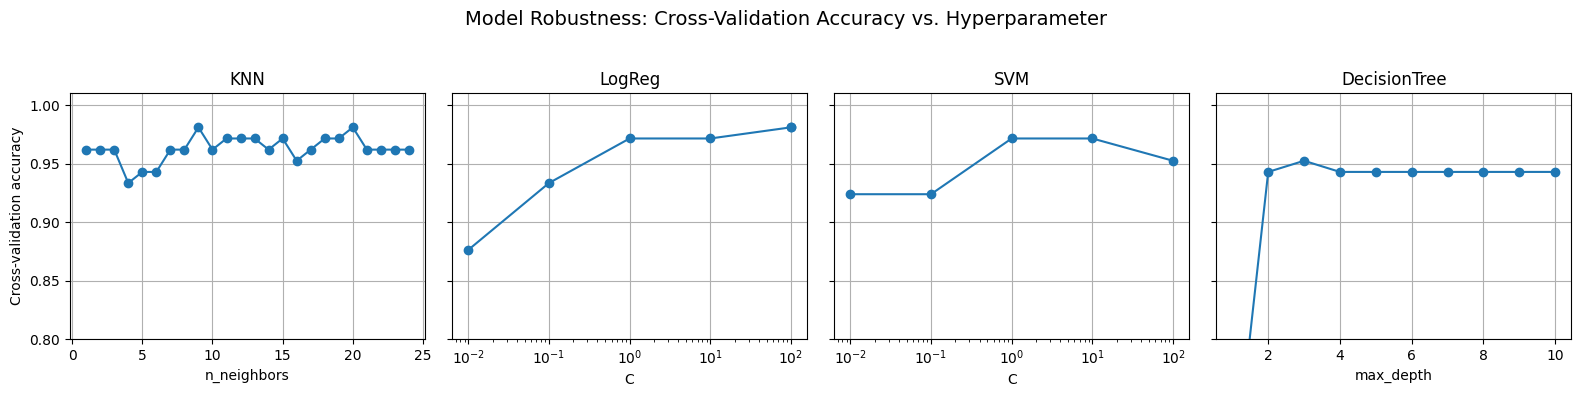

In [43]:
fig, axes = plt.subplots(1, 4, figsize=(16, 4), sharey=True)
fig.suptitle("Model Robustness: Cross-Validation Accuracy vs. Hyperparameter", fontsize=14)

for ax, (name, (x, y)) in zip(axes, cv_results_all.items()):
    ax.plot(x, y, marker="o")
    ax.set_title(name)
    ax.set_xlabel(list(models[name][1].keys())[0])
    ax.set_xscale("log" if list(models[name][1].keys())[0] == "C" else "linear")
    ax.grid(True)
    ax.set_ylim(0.8, 1.01)  # same y-scale for comparability

axes[0].set_ylabel("Cross-validation accuracy")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
